In [1]:
from qbm_utils import *
from qiskit.quantum_info import Pauli
from qiskit.extensions import UGate, RZZGate

### Quantum enhanced MCMC implementation
Aim is to implement the circuit for implementing quantum enhanced MCMC

In [2]:
## put n_spins even always
n_spins = 10

## construct problem Hamiltonian ##
J = np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )

h = np.random.uniform(low= -1, high = 1, size= (n_spins))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )

In [47]:
class IsingEnergyFunction():
    """ A class to build the Ising Hamiltonian 
    
    """
    def __init__(self, J: np.array, h: np.array) -> None:
        self.J = J
        self.h = h
        self.num_spins = len(h)
    
    def get_energy(self, state:Union[str, np.array] )-> float:

        if isinstance(state, str):
            state = np.array( [int(list(s)[i]) for i in range(len(s))])
            energy =  np.dot(state.transpose(), self.J.dot(state)) + np.dot(self.h.transpose(), state )
            return energy
        else:
            return np.dot(state.transpose(), self.J.dot(state)) + np.dot(self.h.transpose(), state )
    
    def get_boltzmann_prob(self, state:Union[str, np.array], beta:float= 1.0) -> float:

        return np.exp( -1 * beta * self.get_energy(state) )
        


In [48]:
enr = IsingEnergyFunction(J, h)

In [49]:
s

'1111111111'

In [50]:
enr.get_energy(s), enr.get_boltzmann_prob(s)

(0.9769800137695706, 0.3764462464043058)

In [46]:
spins = QuantumRegister(n_spins, name= 'spin')
creg_init = ClassicalRegister(n_spins, name= 'creg_0')
creg_final = ClassicalRegister(n_spins, name= 'creg_f')

qc = QuantumCircuit(spins, creg_init, creg_final)
qc.h(spins)
qc.barrier()

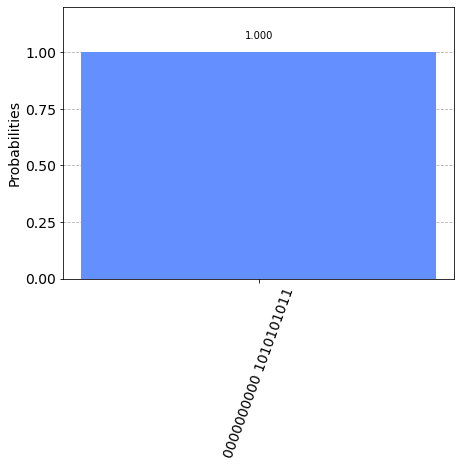

In [9]:
# qc_i = qc.copy()
qc.measure(spins, creg_init)
qc.barrier()
plot_histogram( execute(qc, shots= 1, backend= qsm).result().get_counts() )

In [13]:
num_trotter_steps = 5
for step in range(num_trotter_steps):
    append_evolution(qc, h, J, gamma= np.random.random(), alpha= alpha, time= 0.8)
append_evolution(qc, h, J, gamma= 0.1, alpha= alpha, time= 0.8, is_terminal_step= True)

In [14]:
# qc.draw(output= 'mpl')

In [22]:
# qc_i = qc.copy()
qc.measure(spins, creg_final)
counts =  execute(qc, shots= 2, backend= qsm).result().get_counts() 

In [17]:
transits_probs = [counts.keys()

{'0010010011 1011110101': 1}

In [24]:
list(counts.keys())[0].split(' ') , list(counts.keys())[1].split(' ')

(['1011110110', '1001011110'], ['0000100101', '1101100000'])

In [32]:
s = '1'*10
ss = np.array( [int(list(s)[i]) for i in range(len(s))])

In [36]:
np.dot(J, ss) , J.dot(ss)

(array([ 1.04736728, -0.25364895, -1.91954348, -0.2333103 ,  0.356421  ,
         0.61180832, -0.60933239,  0.03641738, -1.47887935,  0.25417604]),
 array([ 1.04736728, -0.25364895, -1.91954348, -0.2333103 ,  0.356421  ,
         0.61180832, -0.60933239,  0.03641738, -1.47887935,  0.25417604]))